In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

## I - Exploratory Data Analysis

In [3]:
train.shape, test.shape

((891, 12), (418, 11))

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The survived column is our target variable. If Survive = 1 then the passenger survived, and = 0 means that they are deceased.

Non-obvious features:

Pclass: the passenger class. It has three possible values: 1,2,3 (first, second and third class)

SibSp: number of siblings and spouses traveling with the passenger

Parch: number of parents and children traveling with the passenger

Embarked: This describe three possible areas of the Titanic from which the people embark. Three possible values S,C,Q

### Missing Data

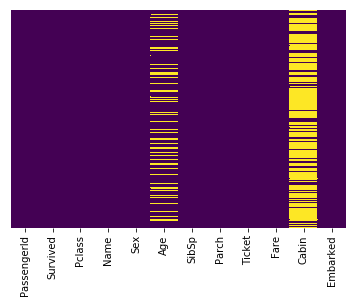

In [5]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

This creates a heatmap of missing data - very useful for visualisation. Age can be salvaged by using replace with mean/median. However, Cabin is more NaN than actual data. 

In [6]:
train['Died'] = 1 - train['Survived']

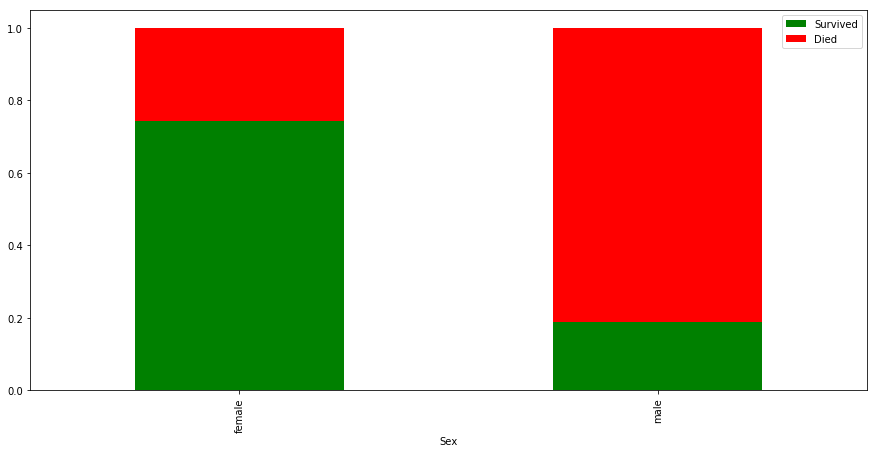

In [7]:
train.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(15, 7), 
                                                           stacked='true', color=['g', 'r']);

The adage of women and children first seems to have been followed on the titanic, as a much higher proportion of men died. 

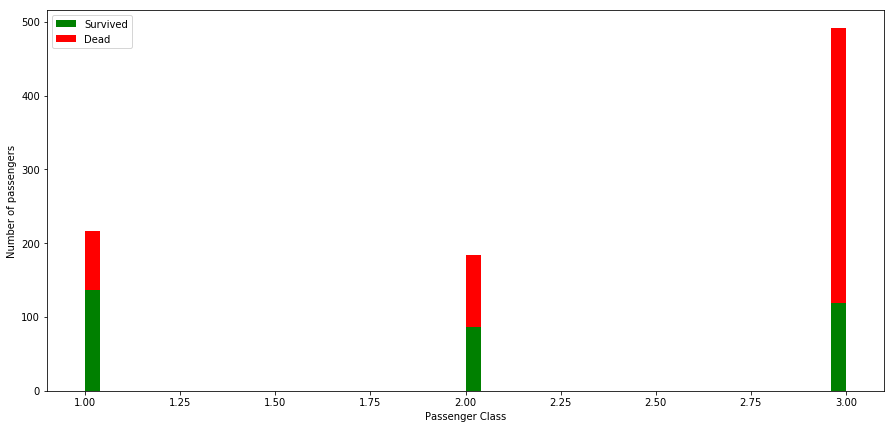

In [8]:
figure1 = plt.figure(figsize=(15, 7))
plt.hist([train[train['Survived'] == 1]['Pclass'], train[train['Died'] == 1]['Pclass']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Passenger Class')
plt.ylabel('Number of passengers')
plt.legend();

This graph shows the survival rates across the different passenger classes. We can see that those in the lower classes had a higher mortality rate. 

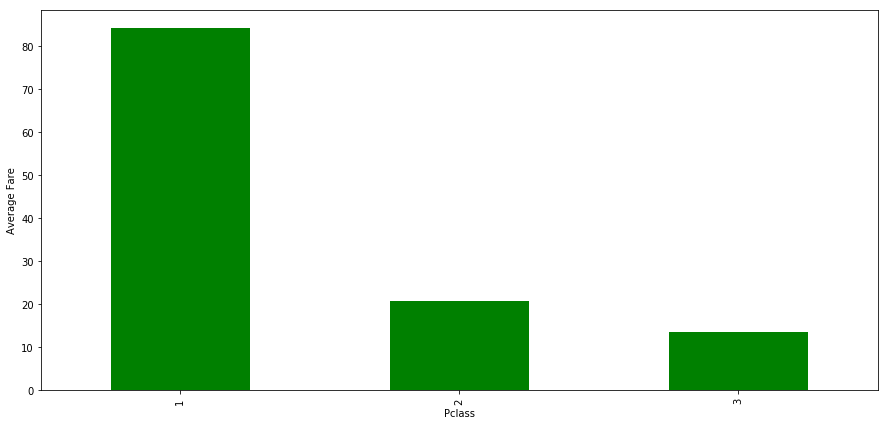

In [9]:
ax = plt.subplot
plt.ylabel('Average Fare')
train.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(15,7), color = 'g')

We can also spot that the fare and class are strongly correlated. 

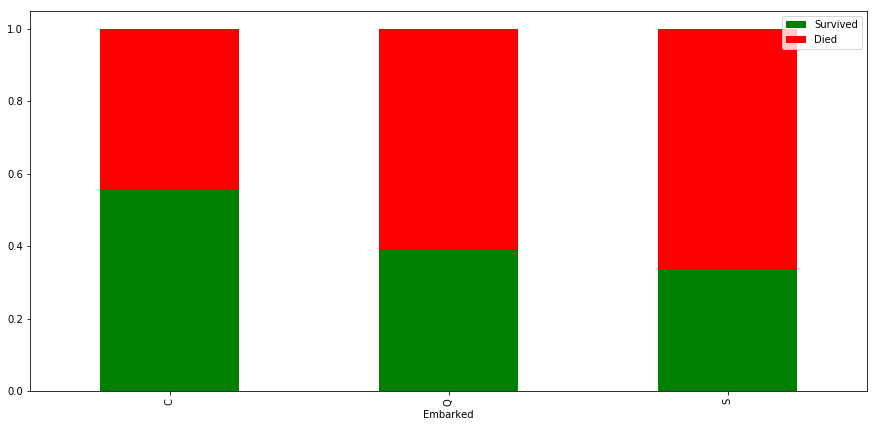

In [10]:
train.groupby('Embarked').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(15, 7), 
                                                           stacked='true', color=['g', 'r']);

Finally, we can see how embarkation sites affected the survival rates of our passengers. 

## Feature Engineering

In [11]:
def add_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return int(train[train["Pclass"] == Pclass]["Age"].mean())
    else:
        return Age

In [12]:
train["Age"] = train[["Age", "Pclass"]].apply(add_age,axis=1)

In [13]:
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Died
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
Died           889 non-null int64
dtypes: float64(2), int64(6), object(4)
memory usage: 90.3+ KB


In [16]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
pclass = pd.get_dummies(train['Pclass'],drop_first=True)

In [17]:
train = pd.concat([train,sex,embark, pclass],axis=1)

In [18]:
train.drop(['Sex','Embarked','Name','Ticket','Died','Pclass'],axis=1,inplace=True)

In [19]:
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,male,Q,S,2,3
0,1,0,22.0,1,0,7.2500,1,0,1,0,1
1,2,1,38.0,1,0,71.2833,0,0,0,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,0,1
3,4,1,35.0,1,0,53.1000,0,0,1,0,0
4,5,0,35.0,0,0,8.0500,1,0,1,0,1


## III - Modelling

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [21]:
X = train.drop("Survived",axis=1)
y = train["Survived"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [23]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
predictions = logmodel.predict(X_test)

In [25]:
from sklearn.metrics import classification_report

In [26]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       163
           1       0.85      0.67      0.75       104

   micro avg       0.83      0.83      0.83       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.83      0.82       267

